# Setup We fix a random seed so that any random examples (if used) behave the same for everyone.

In [1]:
from __future__ import annotations  # Lets us use type hints more cleanly (safe to ignore for now)

from dataclasses import dataclass   # Simple way to define small data containers (used later)
from typing import Callable, List, Tuple  # Type hints for clarity (functions, lists, and pairs)

import numpy as np                  # Numerical computing (arrays, maths, random numbers)
import matplotlib.pyplot as plt     # Plotting (graphs and visualisations)

SEED = 42                           # Constant to make randomness reproducible
rng = np.random.default_rng(SEED)   # Controlled random number generator for this notebook

print("Setup complete, seed =", SEED)  # Quick confirmation that the environment is ready

Setup complete, seed = 42


# Plot the landscape so we can see the peaks and valleys visually

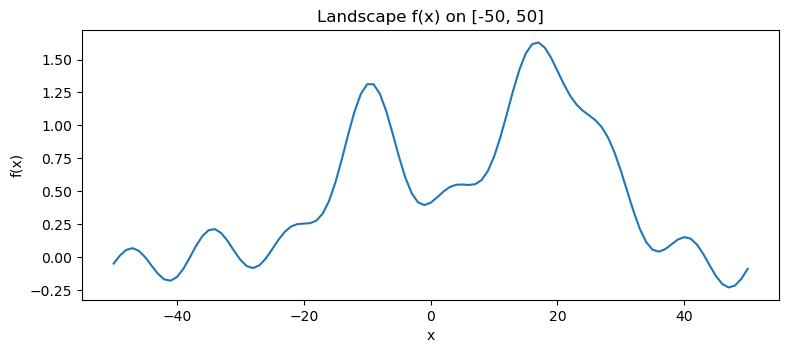

In [2]:
# Define a bumpy landscape (multi-modal) and plot it
# "Multi-modal" means the function has multiple peaks (local maxima),
# which is exactly where hill climbing can get stuck.

def f(x: int) -> float:
    # f(x) is built by combining a few simple patterns:
    # - Two Gaussian "humps" (smooth peaks) centred at x=18 and x=-10
    # - Small sinusoidal ripples (sin/cos) to add extra bumps and plateaus
    #
    # This creates several local maxima, not just one global peak.
    return (
        1.6 * np.exp(-((x - 18) ** 2) / 120)   # Main peak near x = 18 (wider, higher)
        + 1.2 * np.exp(-((x + 10) ** 2) / 60)  # Secondary peak near x = -10 (narrower)
        + 0.15 * np.sin(x / 2)                 # Small oscillations (adds local bumps)
        + 0.08 * np.cos(x / 5)                 # Even smaller oscillations (fine detail)
    )

# Create the integer search space x ∈ {-50, -49, ..., 50}
X = np.arange(-50, 51)

# Evaluate the objective at every x (so we can plot the entire landscape)
Y = np.array([f(int(x)) for x in X])

# Plot the landscape so we can see the peaks and valleys visually
plt.figure(figsize=(9, 3.5))     # Wider figure makes the 1D shape easier to read
plt.plot(X, Y)                   # Draw f(x) for all x in the range
plt.title("Landscape f(x) on [-50, 50]")
plt.xlabel("x")                  # Decision variable
plt.ylabel("f(x)")               # Objective value (what hill climbing tries to maximise)
plt.show()


# Choose a random starting point so different runs can end at different local maxima.

Start x = -41 | f(x) = -0.1767
Final x = -34 | f(x) = 0.2138 | steps = 7


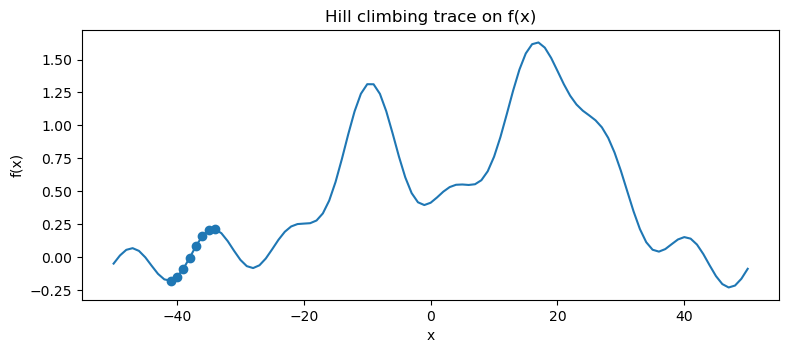

In [3]:
def neighbours_1d(x: int, lo: int = -50, hi: int = 50) -> List[int]:
    # Neighbourhood definition for 1D integer search:
    # from x, you can move one step left (x-1) or one step right (x+1),
    # as long as you stay within the bounds [lo, hi].
    nbs = []
    if x - 1 >= lo:              # Left move is valid
        nbs.append(x - 1)
    if x + 1 <= hi:              # Right move is valid
        nbs.append(x + 1)
    return nbs


def hill_climb_best_improvement(
    start: int,
    objective: Callable[[int], float],
    neighbours: Callable[[int], List[int]],
    max_steps: int = 1000,
) -> Tuple[int, float, List[int]]:
    """Best-improvement hill climbing (steepest ascent).

    At each iteration:
      1) generate neighbours of the current state,
      2) evaluate them using the objective function,
      3) move to the best neighbour if (and only if) it improves the score.

    Returns:
      (final_state, final_score, trace)
      - final_state: where we stopped (a local maximum w.r.t. the neighbourhood)
      - final_score: objective value at that state
      - trace: the sequence of visited states (useful for plotting the path)
    """
    current = start
    current_score = objective(current)
    trace = [current]            # Keep the full path so we can visualise the search

    for _ in range(max_steps):
        cand = neighbours(current)               # Candidate next states (1-step moves)
        scores = [objective(s) for s in cand]    # Evaluate objective for each candidate

        # Pick the neighbour with the highest score (steepest ascent)
        best_i = int(np.argmax(scores))
        best_state = cand[best_i]
        best_score = scores[best_i]

        # Stopping rule:
        # if the best neighbour is not strictly better, we are at a local maximum.
        if best_score <= current_score:
            break

        # Otherwise move "uphill" and continue
        current, current_score = best_state, best_score
        trace.append(current)

    return current, float(current_score), trace

# Choose a random starting point so different runs can end at different local maxima.
# We use rng (seeded earlier) so the run is reproducible for everyone.
start = int(rng.integers(-50, 51))

# Run hill climbing on our landscape f(x)
best_x, best_fx, trace = hill_climb_best_improvement(start, f, neighbours_1d)

# Report the start and the final solution
print("Start x =", start, "| f(x) =", round(f(start), 4))
print("Final x =", best_x, "| f(x) =", round(best_fx, 4), "| steps =", len(trace) - 1)

# Visualise the hill-climbing path on top of the landscape:
# the dots show the visited x values in the order they were chosen.
plt.figure(figsize=(9, 3.5))
plt.plot(X, Y)                                  # The full landscape
plt.scatter(trace, [f(t) for t in trace])       # The hill-climbing trace (visited points)
plt.title("Hill climbing trace on f(x)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()
